In [1]:
import os 
import pandas as pd 
import sys 
import re 

current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path,'..','..','..'))  # '..','..','..'
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
    
from pipeline.plotting.TS_analysis import plot_TS
from jupyter_ipynb.NetMob_training_analysis.plotting import plot_boxplot_on_metric
from experiences.convert_df_to_latex import dataframe_to_latex,parse_index_exp1_2,parse_index_exp4,display_latex_table
from experiences.convert_df_to_latex import update_df_metrics,load_csv,tackle_trial_j
from experiences.common_results import dic_exp_to_names,find_baseline,dic_trials,captions
from experiences.convert_df_to_latex import results_to_dataframe
import importlib 

metrics = ['rmse','mae','mase']

In [2]:
import pandas as pd
import os 

df = pd.read_csv('../../../../../../../../data/rrochas/prediction_validation/agg_data/validation_individuelle/bus_indiv_1H/bus_indiv_1H.csv')
df

/tmp/ipykernel_94487/20127168.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../../../../../../../data/rrochas/prediction_validation/agg_data/validation_individuelle/bus_indiv_1H/bus_indiv_1H.csv')


,Unnamed: 0,LIG_NUMERO_SAE,VAL_ARRET_CODE,CRS_SENS_TRAJET,COD_LIG_CLI,VAL_DATE,Flow
0,0,2,202,1,2,2019-11-01 12:00:00,1
1,1,2,202,1,2,2019-11-02 10:00:00,1
2,2,2,202,1,2,2019-11-02 12:00:00,1
3,3,2,202,1,2,2019-11-04 08:00:00,2
4,4,2,202,1,2,2019-11-04 09:00:00,1
...,...,...,...,...,...,...,...
5871527,5871527,983,40036,0,PL3,2020-03-07 01:00:00,13
5871528,5871528,983,41736,0,PL3,2019-12-21 00:00:00,3
5871529,5871529,983,41736,0,PL3,2019-12-21 01:00:00,10
5871530,5871530,983,44618,0,PL3,2020-02-07 01:00:00,4


In [3]:
pd.to_datetime(df.VAL_DATE).sort_values()

746363    2019-11-01 00:00:00
4610244   2019-11-01 00:00:00
2221461   2019-11-01 00:00:00
3993195   2019-11-01 00:00:00
4858504   2019-11-01 00:00:00
                  ...        
5101886   2020-03-30 23:00:00
3756750   2020-03-30 23:00:00
1170183   2020-03-30 23:00:00
5173466   2020-03-30 23:00:00
3985255   2020-03-30 23:00:00
Name: VAL_DATE, Length: 5871532, dtype: datetime64[ns]

# Load results from saved CSV :

In [4]:
folder_path = 'save/K_fold_validation/training_wo_HP_tuning' # '../../../'  or ''
experiences = ['Exp1_subway_out']# ['Exp1_subway_in','Exp1_subway_out','Exp1']

# ----
Load_from_saved_CSV = False
Load_from_saved_STR = not Load_from_saved_CSV
# ----

for exp_i in experiences:
    trials = dic_trials[exp_i]
    print(f"\n------------------ {exp_i} ---")

    # --- Load from saved CSV :
    if Load_from_saved_CSV:
        L_metrics = []
        for trial_j in trials:
            L_metrics = tackle_trial_j(folder_path,dic_exp_to_names,L_metrics,exp_i,trial_j,metrics,agg = True)
        df_metrics_all = pd.concat(L_metrics)
        df_metrics_all.columns = pd.MultiIndex.from_tuples ([(c[0].split('_')[0].upper(), int(c[0].split('_')[1][1:]),c[1]) for c in df_metrics_all.columns ])
        df_metrics_all.columns.set_names(['metric','horizon','stats'],inplace=True)
        df_metrics_all = df_metrics_all.stack(1)
    # --- 

    # --- Load from saved STR :
    else: 
        result_file = importlib.reload(importlib.import_module(f'experiences.contextual_data_integration.A_homogenous.{exp_i.lower()}_results'))
        df_metrics_all= results_to_dataframe(result_file.results,get_id = True)
        df_metrics_all = df_metrics_all.groupby(['id','horizon'])[['RMSE','MAE','MASE']].agg(['mean','std'])
        df_metrics_all.index = pd.MultiIndex.from_tuples ([('STAEformer_'+c[0]+f'__e80_h{c[1]}',c[1]) for c in df_metrics_all.index], names=['id','horizon'])
    # ----
    

    # horizons = list(set([c[0].split('_')[-1][1:] for c in df_metrics_all.columns]))
    for horizon in list(df_metrics_all.index.levels[1]):
        # df_horizon = df_metrics_all[[c for c in df_metrics_all.columns if c[0].endswith(f"_h{horizon}")]].dropna()
        df_horizon = df_metrics_all.xs(horizon, level='horizon')

        globals()[f"df_metrics_{exp_i}_h{horizon}"] = df_horizon.sort_values(by=[(f'RMSE','mean')])
        baseline_index = find_baseline(exp_i,h=horizon)
        
        for c in globals()[f"df_metrics_{exp_i}_h{horizon}"].columns:
            if 'mean' == c[1]:
                globals()[f"df_metrics_{exp_i}_h{horizon}"][c] = globals()[f"df_metrics_{exp_i}_h{horizon}"][c].apply(lambda x: f"{round(x,3)} ({round(100*(-1+x/globals()[f'df_metrics_{exp_i}_h{horizon}'].loc[baseline_index,c]),2)}\%)")
        
        display(globals()[f"df_metrics_{exp_i}_h{horizon}"])


        # --- Display LaTeX table
        display_latex_table(globals()[f"df_metrics_{exp_i}_h{horizon}"],exp_i,horizon)

# --- Boxplots on metrics





------------------ Exp1_subway_out ---


RMSE  \
                                                                mean   
id                                                                     
STAEformer_subway_out_subway_in_calendar_late_f...  35.381 (-1.85\%)   
STAEformer_subway_out_subway_in_calendar_early_...  35.711 (-0.94\%)   
STAEformer_subway_out_subway_in_calendar_early_...  35.806 (-0.68\%)   
STAEformer_subway_out_subway_in_calendar_early_...  35.841 (-0.58\%)   
STAEformer_subway_out_subway_in_calendar_late_f...  35.872 (-0.49\%)   
STAEformer_subway_out_calendar__e80_h1                 36.05 (0.0\%)   
STAEformer_subway_out_subway_in_calendar_early_...    36.051 (0.0\%)   

                                                              \
                                                         std   
id                                                             
STAEformer_subway_out_subway_in_calendar_late_f...  0.173068   
STAEformer_subway_out_subway_in_calendar_early_...  0.204194   
STAEformer_subway_out_subway_in_calendar_early_...  0.340037   
STAEformer_subway_out_subway_in_calendar_early_...  0.157461   
STAEformer_subway_out_subway_in_calendar_late_f...  0.169972   
STAEformer_subway_out_calendar__e80_h1              0.132654   
STAEformer_subway_out_subway_in_calendar_early_...  0.278197   

                                                                 MAE  \
                                                                mean   
id                                                                     
STAEformer_subway_out_subway_in_calendar_late_f...   19.677 (-2.8\%)   
STAEformer_subway_out_subway_in_calendar_early_...  19.642 (-2.97\%)   
STAEformer_subway_out_subway_in_calendar_early_...   19.76 (-2.39\%)   
STAEformer_subway_out_subway_in_calendar_early_...  19.796 (-2.21\%)   
STAEformer_subway_out_subway_in_calendar_late_f...  20.103 (-0.69\%)   
STAEformer_subway_out_calendar__e80_h1                20.243 (0.0\%)   
STAEformer_subway_out_subway_in_calendar_early_...  19.735 (-2.51\%)   

                                                                         MASE  \
                                                         std             mean   
id                                                                              
STAEformer_subway_out_subway_in_calendar_late_f...  0.111557    0.62 (-2.8\%)   
STAEformer_subway_out_subway_in_calendar_early_...  0.088888  0.618 (-2.97\%)   
STAEformer_subway_out_subway_in_calendar_early_...  0.110347  0.622 (-2.39\%)   
STAEformer_subway_out_subway_in_calendar_early_...  0.060690   0.623 (-2.2\%)   
STAEformer_subway_out_subway_in_calendar_late_f...  0.067318  0.633 (-0.69\%)   
STAEformer_subway_out_calendar__e80_h1              0.078647    0.637 (0.0\%)   
STAEformer_subway_out_subway_in_calendar_early_...  0.069388  0.621 (-2.51\%)   

                                                              
                                                         std  
id                                                            
STAEformer_subway_out_subway_in_calendar_late_f...  0.003513  
STAEformer_subway_out_subway_in_calendar_early_...  0.002799  
STAEformer_subway_out_subway_in_calendar_early_...  0.003476  
STAEformer_subway_out_subway_in_calendar_early_...  0.001912  
STAEformer_subway_out_subway_in_calendar_late_f...  0.002119  
STAEformer_subway_out_calendar__e80_h1              0.002475  
STAEformer_subway_out_subway_in_calendar_early_...  0.002184


------------------------------------------------
%%% LaTeX code for Experiment Exp1_subway_out Horizon +15min Table %%%

\begin{table}[!htb]
    \centering
    \caption{Prediction of Subway-Out with STAEformer using contextual data 'Subway-In' according to different Integration Strategies. Metrics are averaged over 5 runs.}
    \label{tab:Exp1_subway_out}
    \resizebox{\textwidth}{!}{
    \begin{tabular}{{llcccccc}}
        \toprule
        Contextual Data & Integration Strategy & \multicolumn{2}{c}{ RMSE (h1) } & \multicolumn{2}{c}{ MAE (h1) } & \multicolumn{2}{c}{ MASE (h1) } \\
        \cmidrule(lr){1-2} \cmidrule(lr){3-4} \cmidrule(lr){5-6} \cmidrule(lr){7-8}
         &  & Mean & Std & Mean & Std & Mean & Std \\
        \midrule
        Yes & Late Fusion Traffic Model Backbone Inemb24 Adp16 & 35.381 (-1.85\%) & 0.1731 & 19.677 (-2.8\%) & 0.1116 & 0.62 (-2.8\%) & 0.0035 \\
        Yes & Early Fusion Traffic Model Backbone Inemb24 Adp16 & 35.711 (-0.94\%) & 0.2042 & 19.642 (-2.97\%

RMSE  \
                                                                mean   
id                                                                     
STAEformer_subway_out_subway_in_calendar_early_...   40.59 (-2.36\%)   
STAEformer_subway_out_subway_in_calendar_early_...  40.807 (-1.84\%)   
STAEformer_subway_out_subway_in_calendar_early_...  40.881 (-1.66\%)   
STAEformer_subway_out_subway_in_calendar_early_...  41.109 (-1.11\%)   
STAEformer_subway_out_calendar__e80_h4                41.572 (0.0\%)   
STAEformer_subway_out_subway_in_calendar_late_f...   41.881 (0.74\%)   
STAEformer_subway_out_subway_in_calendar_late_f...   41.895 (0.78\%)   

                                                              \
                                                         std   
id                                                             
STAEformer_subway_out_subway_in_calendar_early_...  0.565568   
STAEformer_subway_out_subway_in_calendar_early_...  0.313664   
STAEformer_subway_out_subway_in_calendar_early_...  0.292803   
STAEformer_subway_out_subway_in_calendar_early_...  0.184949   
STAEformer_subway_out_calendar__e80_h4              0.366829   
STAEformer_subway_out_subway_in_calendar_late_f...  0.500660   
STAEformer_subway_out_subway_in_calendar_late_f...  0.148227   

                                                                 MAE  \
                                                                mean   
id                                                                     
STAEformer_subway_out_subway_in_calendar_early_...  22.175 (-2.77\%)   
STAEformer_subway_out_subway_in_calendar_early_...  22.547 (-1.14\%)   
STAEformer_subway_out_subway_in_calendar_early_...  22.288 (-2.28\%)   
STAEformer_subway_out_subway_in_calendar_early_...  22.553 (-1.12\%)   
STAEformer_subway_out_calendar__e80_h4                22.807 (0.0\%)   
STAEformer_subway_out_subway_in_calendar_late_f...    22.854 (0.2\%)   
STAEformer_subway_out_subway_in_calendar_late_f...   22.952 (0.64\%)   

                                                                         MASE  \
                                                         std             mean   
id                                                                              
STAEformer_subway_out_subway_in_calendar_early_...  0.180954  0.419 (-2.77\%)   
STAEformer_subway_out_subway_in_calendar_early_...  0.218741  0.426 (-1.14\%)   
STAEformer_subway_out_subway_in_calendar_early_...  0.155753  0.421 (-2.28\%)   
STAEformer_subway_out_subway_in_calendar_early_...  0.119013  0.426 (-1.11\%)   
STAEformer_subway_out_calendar__e80_h4              0.205140     0.43 (0.0\%)   
STAEformer_subway_out_subway_in_calendar_late_f...  0.205195   0.431 (0.21\%)   
STAEformer_subway_out_subway_in_calendar_late_f...  0.108601   0.433 (0.64\%)   

                                                              
                                                         std  
id                                                            
STAEformer_subway_out_subway_in_calendar_early_...  0.003416  
STAEformer_subway_out_subway_in_calendar_early_...  0.004128  
STAEformer_subway_out_subway_in_calendar_early_...  0.002938  
STAEformer_subway_out_subway_in_calendar_early_...  0.002247  
STAEformer_subway_out_calendar__e80_h4              0.003872  
STAEformer_subway_out_subway_in_calendar_late_f...  0.003871  
STAEformer_subway_out_subway_in_calendar_late_f...  0.002047


------------------------------------------------
%%% LaTeX code for Experiment Exp1_subway_out Horizon +60min Table %%%

\begin{table}[!htb]
    \centering
    \caption{Prediction of Subway-Out with STAEformer using contextual data 'Subway-In' according to different Integration Strategies. Metrics are averaged over 5 runs.}
    \label{tab:Exp1_subway_out}
    \resizebox{\textwidth}{!}{
    \begin{tabular}{{llcccccc}}
        \toprule
        Contextual Data & Integration Strategy & \multicolumn{2}{c}{ RMSE (h4) } & \multicolumn{2}{c}{ MAE (h4) } & \multicolumn{2}{c}{ MASE (h4) } \\
        \cmidrule(lr){1-2} \cmidrule(lr){3-4} \cmidrule(lr){5-6} \cmidrule(lr){7-8}
         &  & Mean & Std & Mean & Std & Mean & Std \\
        \midrule
        Yes & Early Fusion Shared Embedding & 40.59 (-2.36\%) & 0.5656 & 22.175 (-2.77\%) & 0.1810 & 0.419 (-2.77\%) & 0.0034 \\
        Yes & Early Fusion-S-Proj-T-Proj & 40.807 (-1.84\%) & 0.3137 & 22.547 (-1.14\%) & 0.2187 & 0.426 (-1.14\%) & 0.0041 \\

# Plot distribution :

In [13]:
import pandas as pd
import numpy as np 
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.palettes import Category10
from bokeh.transform import factor_cmap
from bokeh.plotting import figure 
from bokeh.models import ColumnDataSource, Toggle, CustomJS,HoverTool, Legend,Model
from bokeh.layouts import layout,row,column
from bokeh.resources import CDN
from bokeh.io import reset_output,show, output_file, save,output_notebook
from bokeh.transform import dodge





# experiences = ['Exp1_subway_in','Exp1_subway_out','Exp1']
exp_i = 'Exp1_subway_out' # 'Exp1_subway_out' #'Exp1_subway_in' # 'Exp1' 
metrics = ['rmse','mae','mase']
trials = dic_trials[exp_i]
print(f"\n------------------ {exp_i} ---")

Load_from_saved_CSV = False
# --- Load from saved CSV :
if Load_from_saved_CSV:
    L_metrics = []
    for trial_j in trials:
        L_metrics = tackle_trial_j(folder_path,dic_exp_to_names,L_metrics,exp_i,trial_j,metrics,agg = False)
    df_metrics_all = pd.concat(L_metrics)
# --- 

# --- Load from saved STR :
else: 
    result_file = importlib.reload(importlib.import_module(f'experiences.contextual_data_integration.A_homogenous.{exp_i.lower()}_results'))
    df_metrics_all= results_to_dataframe(result_file.results,get_id = True)
    df_metrics_all['id'] = df_metrics_all.apply(lambda row : f"STAEformer_{row['id']}__e80_h{row['horizon']}_bis{row['bis']}", axis=1)
    df_metrics_all = df_metrics_all.drop(columns=['target','contextual_data','percentage','bis'])
    df_metrics_all = df_metrics_all.set_index(['id','horizon'])
    df_metrics_all = df_metrics_all.unstack(1)
    df_metrics_all.columns = [f"{c[0].lower()}_h{c[1]}" for c in df_metrics_all.columns]
    df_metrics_all.index.name = None

def change_legend(row):
    if row.legend_group == 'Other Methods':
        if 'early_fusion' in row.name:
            return 'Early Fusion Other Methods '
        elif 'late_fusion' in row.name:
            return 'Late Fusion Other Methods '
        else:
            return row.legend_group
    else:
        return row.legend_group

def reduce_id(x):
    x = x.replace('late_fusion_','L_')
    x = x.replace('early_fusion_','E_')
    x = x.replace('backbone','BB')
    return x 


configs_to_keep = [
    'Baseline',
    # Model backbone : ---- 
    'late_fusion_traffic_model_backbone_In24_adp16',
    'early_fusion_traffic_model_backbone_In24_adp16',
    # CABB with adpQ = 0 ---
    'early_fusion_CABB_In24_ctxIn8_adp16_adpQ0',
    'late_fusion_CABB_In24_ctxIn8_adp16_adpQ0',
    # CABB with adpQ = 24 ---
    'early_fusion_CABB_In24_ctxIn8_adp16_adpQ24',
    'late_fusion_CABB_In24_ctxIn8_adp16_adpQ24',
    # 'early_fusion_CABB_In24_ctxIn24_adp16_adpQ24',
    # 'late_fusion_CABB_In24_ctxIn24_adp16_adpQ24',
    
    # Others ---
    'late_fusion_simple_embedding',
    'early_fusion_shared_embedding',
    'early_fusion_independant_embedding'   
] 
# configs_to_keep = None 

# palette = ['#4e79a7','#f28e2b','#e15759', '#59a14f', '#c7e9c0','#1a4314' ]
# legend_groups = ['Baseline','Independant Embedding','Shared Embedding','Early Fusion Other Methods ','Late Fusion Other Methods ']
palette = ['#4e79a7','#f28e2b' ]
legend_groups = ['Baseline','Others']
horizons = list(set([c.split('_')[-1][1:] for c in df_metrics_all.columns]))
for horizon in horizons:
    print('\n----------------')
    print(f"Horizon: {horizon}")
    df_horizon = df_metrics_all[[c for c in df_metrics_all.columns if c.endswith(f"_h{horizon}")]].dropna()

    df_horizon = update_df_metrics(df_horizon,exp_i)
    df_horizon['legend_group'] = df_horizon.apply(change_legend,axis = 1)

    if configs_to_keep is not None: 
        df_horizon = df_horizon[df_horizon['id'].isin(configs_to_keep)]
        df_horizon['id'] = df_horizon['id'].apply(reduce_id)

    df_horizon['id'] = df_horizon['id'].apply(lambda x: x.replace('_In24_adp16',''))

    df_horizon['id'] = df_horizon['id'].apply(lambda x: x.replace('E_independant_embedding','E Independant Emb'
                                                              ).replace('E_shared_embedding','E Shared Emb'
                                                              ).replace('E_traffic_model_BB','E Backbone'
                                                            ).replace('L_independant_embedding','L Independant Emb'
                                                              ).replace('L_shared_embedding','L Shared Emb'
                                                              ).replace('L_traffic_model_BB','L Backbone'      
                                                            ).replace('L_simple_embedding','L Simple Emb'
                                                            )                                                             
                                )
    df_horizon['legend_group'] = df_horizon['legend_group'].apply(lambda x: 'Others' if x not in ['Baseline'] else x)


    title = f'RMSE Distribution per Config and Fusion Strategy of Subway-In Prediction at Horizon [{15*(int(horizon)-1)} - {15*(int(horizon))}]min'
    plot_boxplot_on_metric(df_horizon, metric_i='rmse', xaxis_label="Config", legend_group='legend_group', width=800, height=600, 
                                save_path=None,palette =palette ,legend_groups =legend_groups,title = title)
    
    title = 'MASE Distribution per Integration Strategy of Subway-In Prediction at\n' + f'Horizon [{15*(int(horizon)-1)} - {15*(int(horizon))}]min'
    plot_boxplot_on_metric(df_horizon, metric_i='mase', xaxis_label="Config", legend_group='legend_group', width=800, height=600, 
                                save_path=None,palette =palette ,legend_groups =legend_groups,title = title)
    # plot_boxplot_on_metric(df_horizon, metric_i='mase', xaxis_label="Config", legend_group='legend_group', width=1200, height=400, 
    #                             save_path=None)
    


------------------ Exp1_subway_out ---

----------------
Horizon: 1


Loading BokehJS ...

Loading BokehJS ...


----------------
Horizon: 4


Loading BokehJS ...

Loading BokehJS ...

In [4]:
import os 
import sys 

current_path = os.path.abspath(os.getcwd())
parent_dir = os.path.abspath(os.path.join(current_path, '..','..','..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from examples.accuracy_comparison import load_trainer_ds_from_2_trials,get_predict_real_and_inputs,get_model_args
from examples.accuracy_comparison import get_rainy_indices,plot_analysis_comparison_2_config,get_previous_and_prediction,get_gain_from_mod1
import torch 
from pipeline.utils.metrics import evaluate_metrics

def get_dict_metrics_on_rainy_events(full_predict1,full_predict2,Y_true,X,args_init1,args_init2,ds2):
    h_idx = 1
    metric_list = ['rmse','mse','mae','mase','mape']
    previous,_,_,_ = get_previous_and_prediction(full_predict1,full_predict2,Y_true,X,h_idx)
    assert args_init1.horizon_step == args_init1.step_ahead, "Horizon step must be equal to step_ahead here"

    print("\nComparison on between models across all time-slots followed by comparison on Rainy Events Only")
    _,train_rainy_indices,_ = get_rainy_indices(args = args_init2,ds = ds2,training_mode = 'train')
    print(f"Number of rainy time-slots in the train set: {len(train_rainy_indices)}, i.e {len(train_rainy_indices)/len(ds2.tensor_limits_keeper.df_verif_train)*100:.2f} % of the train set")
    # ---- Plot Accuracy comparison on rainy moments only ----
    mask,rainy_indices,df_weather = get_rainy_indices(args = args_init2,ds = ds2,training_mode = 'test')
    print(f"Number of rainy time-slots in the test set: {len(rainy_indices)}, i.e {len(rainy_indices)/len(ds2.tensor_limits_keeper.df_verif_test)*100:.2f} % of the test set\n")

    dates = mask[mask].index
    masked_index = mask.reset_index(drop=True)
    masked_index = masked_index[masked_index].index


    # --- Get Prediction on rainy time-slots:
    rainy_predict1 = torch.index_select(full_predict1,0,torch.tensor(masked_index).long())
    rainy_predict2 = torch.index_select(full_predict2,0,torch.tensor(masked_index).long())
    rainy_Y_true = torch.index_select(Y_true,0,torch.tensor(masked_index).long())
    rainy_previous = torch.index_select(previous,0,torch.tensor(masked_index).long())

    dic_metric1 = evaluate_metrics(rainy_predict1,rainy_Y_true,metrics = metric_list, previous = rainy_previous,horizon_step = h_idx)
    dic_metric1 = dict(dic_metric1.copy())
    dic_metric2 = evaluate_metrics(rainy_predict2,rainy_Y_true,metrics = metric_list, previous = rainy_previous,horizon_step = h_idx)
    dic_metric2 = dict(dic_metric2.copy())
    return dic_metric1,dic_metric2



dic_contextual_data = {'bike_out': [[]],  #,['weather','calendar']
                    }

dic_fusion_strategie = {('bike_out',()): [''],
                        ('bike_out',('weather','calendar')):['early_fusion','late_fusion'],
                        }
             
dic_feature_extractor = {('bike_out',()): [''],
                        ('bike_out',('weather','calendar')):['repeat_t_proj','feature_extractor']
                        }


model_name = 'STAEformer'
epochs = 200
range_k = range(1,6)
training_mode = 'test'
modification = {'shuffle':False,
                'data_augmentation':False,
                'torch_compile': False,
                }
log = ''
Exp = 'Exp2'  # 'Exp2'

for horizon in [4]:
    for target in ['bike_out']:
        for contextual_data in dic_contextual_data[target]:
            reversed_metric = False
            fusion_strategies = dic_fusion_strategie[(target,tuple(contextual_data))]
            for fusion_strategie in fusion_strategies:
                feature_extractors = dic_feature_extractor[(target,tuple(contextual_data))]
                for feature_extractor in feature_extractors:
                    if not('weather' in contextual_data):
                        print('\n------------------------------------------------------\nContextual data:\n')
                        contextual_data1 = ['weather','calendar'] if target == 'bike_out' else ['subway_in','weather','calendar']
                        fusion_strategie1 = dic_fusion_strategie[(target,tuple(contextual_data1))][0]
                        feature_extractor1 = dic_feature_extractor[(target,tuple(contextual_data1))][0]

                        trial_id1 = f"{model_name}_{target}_calendar__e{epochs}_h{horizon}_bis"
                        trial_id2 = f"{model_name}_{target}_{'_'.join(contextual_data1)}_{fusion_strategie1}_{feature_extractor1}__e{epochs}_h{horizon}_bis"
                        reversed_metric = True 
                    else:
                        trial_id1 = f"{model_name}_{target}_calendar__e{epochs}_h{horizon}_bis"
                        trial_id2 = f"{model_name}_{target}_{'_'.join(contextual_data)}_{fusion_strategie}_{feature_extractor}__e{epochs}_h{horizon}_bis"

                    model_args,_,path_model_args,_ = get_model_args(target,model_name,save_folder_name = f'{Exp}/{target}_{model_name}')
                    ds1,ds2,args_init1,args_init2 = None, None, None, None
                    for k in range_k:
                        trial_id1_updated = f"{trial_id1}{k}_f5"
                        trial_id2_updated = f"{trial_id2}{k}_f5"

                        trainer1,trainer2,ds1,ds2,args_init1,args_init2 = load_trainer_ds_from_2_trials(trial_id1_updated,trial_id2_updated,modification = modification,
                                                                                                        model_args=model_args,
                                                                                                        path_model_args=path_model_args,
                                                                                                        ds1_init=ds1,ds2_init=ds2,
                                                                                                        args_init1=args_init1,args_init2=args_init2,
                                                                                                        )
                                                                                                        

                        full_predict1,full_predict2,Y_true,X = get_predict_real_and_inputs(trainer1,trainer2,ds1,ds2,training_mode=training_mode)

                        globals()[f"trainer1_bis{k}"] = trainer1
                        globals()[f"trainer2_bis{k}"] = trainer2
                        globals()[f"ds1_bis{k}"] = ds1
                        globals()[f"ds2_bis{k}"] = ds2
                        globals()[f"full_predict1_bis{k}"] = full_predict1
                        globals()[f"full_predict2_bis{k}"] = full_predict2

                        dic_metric1,dic_metric2 = get_dict_metrics_on_rainy_events(globals()[f"full_predict1_bis{k}"],globals()[f"full_predict2_bis{k}"],Y_true,X,args_init1,args_init2,ds2)

                        # Keep track on metric from model 1
                        if reversed_metric:
                            dic_metric2 = dict(dic_metric1.copy())
                        RMSE = dic_metric2['rmse_all']
                        MAE = dic_metric2['mae_all']
                        MASE = dic_metric2['mase_all']
                        MAPE = dic_metric2['mape_all']
                        if feature_extractor == []:
                            log += f"{model_name}_{target}__e{epochs}_h{horizon}_bis{k}:   All Steps RMSE = {RMSE:.3f}, MAE = {MAE:.3f}, MASE = {MASE:.3f}, MAPE = {MAPE:.3f}\n"
                        else:
                            log += f"{model_name}_{target}_{'_'.join(contextual_data)}_{fusion_strategie}_{feature_extractor}__e{epochs}_h{horizon}_bis{k}:   All Steps RMSE = {RMSE:.3f}, MAE = {MAE:.3f}, MASE = {MASE:.3f}, MAPE = {MAPE:.3f}\n"

                    print(log)

/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No module xgboost
Training and Hyper-parameter tuning with Ray is not possible
Training and Hyper-parameter tuning with Ray is not possible


------------------------------------------------------
Contextual data:



TypeError: get_model_args() got multiple values for argument 'save_folder_name'

# Load Results from saved str:

In [5]:
import os 
import sys 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path,'..','..','..'))  # '..','..','..'
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)


from experiences.contextual_data_integration.A_homogenous.exp1_subway_out_results import results as results_subway_out


# ---- Load results from saved str: ---- 
ref_id = 'subway_out_calendar'
df_metrics_all = results_to_dataframe(results_subway_out,get_id = True)

for horizon in [1,4]:
    df_h1 = df_metrics_all[df_metrics_all.horizon == horizon]
    df_h1_agg = df_h1.groupby(['target','contextual_data','horizon','id']).mean().reset_index()

    # --- Compute Gain on the Average of MASE
    for metric in ['RMSE','MAE','MASE']:
        ref_metric = df_h1_agg[(df_h1_agg['id'] == ref_id )][metric].values[0]
        df_h1_agg[f'{metric}_Gain_%'] = df_h1_agg.apply(lambda row: '{:.2f}'.format(100*(row[metric]-ref_metric)/ref_metric), axis=1)
        df_h1_agg[f'{metric}_std'] = df_h1.groupby(['target','contextual_data','horizon','id'])[metric].std().reset_index()[metric]
    display(df_h1_agg.sort_values(by=['MASE']))

    latex_table = dataframe_to_latex(df_h1_agg,
                                        caption= f"Performance metrics for {exp_i} at horizon {horizon}",
                                        label = 'exp1_subway_out_h1_context',
                                        index_parser = 
                                        parse_index_exp1_2 if exp_i in ['Exp1_subway_in','Exp1_subway_out','Exp1'] else parse_index_exp4)
    print(latex_table)

# ---- Plot Desagregated Gains : ----
from experiences.common_results import dic_exp_to_names,dic_trials
from experiences.get_desagregated_plot import get_desagregated_gains
exp = 'Exp1_subway_out'
dic_trials = {exp: dic_trials[exp]}
dic_exp_to_names = {exp: dic_exp_to_names[exp]}
horizons = [4,1]
comparison_on_rainy_events = False
range_k = range(1,6)
station_clustering = True
folder_path = 'save'

get_desagregated_gains(dic_exp_to_names,dic_trials,horizons,comparison_on_rainy_events,range_k,station_clustering,folder_path,save_bool=False)


,target,contextual_data,horizon,id,percentage,bis,RMSE,MAE,MASE,RMSE_Gain_%,RMSE_std,MAE_Gain_%,MAE_std,MASE_Gain_%,MASE_std
4,subway_out,subway_out + subway in,1,subway_out_subway_in_calendar_early_fusion_tra...,-1.0,3.0,35.710552,19.642188,0.618470,-0.94,0.204194,-2.97,0.088888,-2.97,0.002799
6,subway_out,subway_out + subway in,1,subway_out_subway_in_calendar_late_fusion_traf...,-1.0,3.0,35.381452,19.676578,0.619554,-1.85,0.173068,-2.80,0.111557,-2.80,0.003513
3,subway_out,subway_out + subway in,1,subway_out_subway_in_calendar_early_fusion_sha...,-1.0,3.0,36.050802,19.735290,0.621402,0.00,0.278197,-2.51,0.069388,-2.51,0.002184
2,subway_out,subway_out + subway in,1,subway_out_subway_in_calendar_early_fusion_s_p...,-1.0,3.0,35.806160,19.759624,0.622170,-0.68,0.340037,-2.39,0.110347,-2.39,0.003476
1,subway_out,subway_out + subway in,1,subway_out_subway_in_calendar_early_fusion_ind...,-1.0,3.0,35.840728,19.796140,0.623320,-0.58,0.157461,-2.21,0.060690,-2.20,0.001912
5,subway_out,subway_out + subway in,1,subway_out_subway_in_calendar_late_fusion_simp...,-1.0,3.0,35.871662,20.103162,0.632984,-0.49,0.169972,-0.69,0.067318,-0.69,0.002119
0,subway_out,subway_out,1,subway_out_calendar,-1.0,3.0,36.049616,20.242582,0.637372,0.00,0.132654,0.00,0.078647,0.00,0.002475


\begin{table}[!htb]
    \centering
    \caption{Performance metrics for Exp1_subway_out at horizon 1}
    \label{tab:exp1_subway_out_h1_context}
    \resizebox{\textwidth}{!}{
    \begin{tabular}{{llcccccc}}
        \toprule
        Contextual Data & Integration Strategy & \multicolumn{2}{c}{ RMSE (h1) } & \multicolumn{2}{c}{ MAE (h1) } & \multicolumn{2}{c}{ MASE (h1) } \\
        \cmidrule(lr){1-2} \cmidrule(lr){3-4} \cmidrule(lr){5-6} \cmidrule(lr){7-8}
         &  & Mean & Std & Mean & Std & Mean & Std \\
        \midrule
        Yes & Late Fusion Traffic Model Backbone Inemb24 Adp16 & 35.381 (-3.88\%) & 0.1731 & 19.677 (-3.51\%) & 0.1116 & 0.612 (-3.06\%) & 0.0035 \\
        Yes & Early Fusion Traffic Model Backbone Inemb24 Adp16 & 35.711 (-2.99\%) & 0.2042 & 19.642 (-3.68\%) & 0.0889 & 0.611 (-3.23\%) & 0.0028 \\
        Yes & Early Fusion-S-Proj-T-Proj & 35.806 (-2.73\%) & 0.3400 & 19.76 (-3.11\%) & 0.1103 & 0.615 (-2.65\%) & 0.0034 \\
        Yes & Early Fusion Independant Embed

,target,contextual_data,horizon,id,percentage,bis,RMSE,MAE,MASE,RMSE_Gain_%,RMSE_std,MAE_Gain_%,MAE_std,MASE_Gain_%,MASE_std
3,subway_out,subway_out + subway in,4,subway_out_subway_in_calendar_early_fusion_sha...,-1.0,3.0,40.589914,22.175308,0.418534,-2.36,0.565568,-2.77,0.180954,-2.77,0.003416
4,subway_out,subway_out + subway in,4,subway_out_subway_in_calendar_early_fusion_tra...,-1.0,3.0,40.881100,22.288154,0.420664,-1.66,0.292803,-2.28,0.155753,-2.28,0.002938
2,subway_out,subway_out + subway in,4,subway_out_subway_in_calendar_early_fusion_s_p...,-1.0,3.0,40.807380,22.547290,0.425554,-1.84,0.313664,-1.14,0.218741,-1.14,0.004128
1,subway_out,subway_out + subway in,4,subway_out_subway_in_calendar_early_fusion_ind...,-1.0,3.0,41.109006,22.553092,0.425664,-1.11,0.184949,-1.12,0.119013,-1.11,0.002247
0,subway_out,subway_out,4,subway_out_calendar,-1.0,3.0,41.571956,22.807480,0.430462,0.00,0.366829,0.00,0.205140,0.00,0.003872
6,subway_out,subway_out + subway in,4,subway_out_subway_in_calendar_late_fusion_traf...,-1.0,3.0,41.881336,22.854146,0.431348,0.74,0.500660,0.20,0.205195,0.21,0.003871
5,subway_out,subway_out + subway in,4,subway_out_subway_in_calendar_late_fusion_simp...,-1.0,3.0,41.894790,22.952432,0.433202,0.78,0.148227,0.64,0.108601,0.64,0.002047


\begin{table}[!htb]
    \centering
    \caption{Performance metrics for Exp1_subway_out at horizon 4}
    \label{tab:exp1_subway_out_h1_context}
    \resizebox{\textwidth}{!}{
    \begin{tabular}{{llcccccc}}
        \toprule
        Contextual Data & Integration Strategy & \multicolumn{2}{c}{ RMSE (h4) } & \multicolumn{2}{c}{ MAE (h4) } & \multicolumn{2}{c}{ MASE (h4) } \\
        \cmidrule(lr){1-2} \cmidrule(lr){3-4} \cmidrule(lr){5-6} \cmidrule(lr){7-8}
         &  & Mean & Std & Mean & Std & Mean & Std \\
        \midrule
        Yes & Early Fusion Shared Embedding & 40.59 (-4.14\%) & 0.5656 & 22.175 (-3.7\%) & 0.1810 & 0.69 (-3.2\%) & 0.0056 \\
        Yes & Early Fusion-S-Proj-T-Proj & 40.807 (-3.63\%) & 0.3137 & 22.547 (-2.08\%) & 0.2187 & 0.702 (-1.58\%) & 0.0068 \\
        Yes & Early Fusion Traffic Model Backbone Inemb24 Adp16 & 40.881 (-3.45\%) & 0.2928 & 22.288 (-3.21\%) & 0.1558 & 0.694 (-2.71\%) & 0.0048 \\
        Yes & Early Fusion Independant Embedding & 41.109 (-2.91\%

/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No module xgboost
Training and Hyper-parameter tuning with Ray is not possible
Training and Hyper-parameter tuning with Ray is not possible

Exp1_subway_out
Trial id Ref:  STAEformer_subway_out_calendar__e80_h4_bis
Trial id to test: 
STAEformer_subway_out_subway_in_calendar_early_fusion_independant_embedding__e80_h4_bis
STAEformer_subway_out_subway_in_calendar_early_fusion_s_proj_t_proj__e80_h4_bis
STAEformer_subway_out_subway_in_calendar_late_fusion_traffic_model_backbone_InEmb24_adp16__e80_h4_bis
STAEformer_subway_out_subway_in_calendar_early_fusion_shared_embedding__e80_h4_bis
STAEformer_subway_out_subway_in_calendar_early_fusion_traffic_model_backbone_InEmb24_adp16__e80_h4_bis
STAEformer_subway_out_subway_in_calendar_late_fusion_simple_embedding__e80_h4_bis
Trial ID 1:  _STAEformer_subway_out_calendar__e80_h4_bis1_f5
Trial ID 2:  _STAEformer_subway_out_subway_in_calendar_early_fusion_independant_embedding__e80_h4_bis1_f5
model_save_path for trial id1:  /home/rrochas/prediction-vali

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f099cffd3c0>>
Traceback (most recent call last):
  File "/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 



>>>Tackle Contextual dataset:  subway_in
   Load data from: //home/rrochas/../../data/rrochas/prediction_validation/subway_in/subway_in.csv


Restraining all datasets to train common dates: 14962 dates
Restraining all datasets to valid common dates: 4987 dates
Restraining all datasets to test common dates: 4987 dates

Size of Contextual datasets:
   Init Dataset: '[torch.Size([35040, 40])]
   TRAIN contextual_ds: [torch.Size([14962, 40, 7])]
   VALID contextual_ds: [torch.Size([4987, 40, 7])]
   TEST contextual_ds: [torch.Size([4987, 40, 7])]
Init U/Utarget size: torch.Size([24937, 40, 7])/torch.Size([24937, 40, 1]) Train/Valid/Test 14962 4987 4987

 ===== ERROR WITH prefetch_factor====  
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing

----------------------------------------
Loading the dataset for fold n°5
  add last fold : the initil one
Model size: 0.003GB
Trial ID 1:  _STAEformer_subway_out_calendar__e80

Trial ID 1:  _STAEformer_subway_out_calendar__e80_h4_bis3_f5
Trial ID 2:  _STAEformer_subway_out_subway_in_calendar_early_fusion_independant_embedding__e80_h4_bis3_f5
model_save_path for trial id1:  /home/rrochas/prediction-validation/save/K_fold_validation/training_wo_HP_tuning/Exp1_subway_out/subway_out_STAEformer/best_models/STAEformer_subway_out_calendar__e80_h4_bis3_f5.pkl
Model size: 0.002GB
model_save_path for trial id2:  /home/rrochas/prediction-validation/save/K_fold_validation/training_wo_HP_tuning/Exp1_subway_out/subway_out_STAEformer/best_models/STAEformer_subway_out_subway_in_calendar_early_fusion_independant_embedding__e80_h4_bis3_f5.pkl
Model size: 0.003GB


Exception in thread Thread-15 (_pin_memory_loop):
Traceback (most recent call last):
  File "/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/torch/utils/data/_utils/pin_memory.py", line 51, in _pin_memory_loop
    do_one_step()
  File "/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/torch/utils/data/_utils/pin_memory.py", line 28, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
  File "/root/an

KeyboardInterrupt: 

## Load saved model and get NEW results: 

In [3]:
import os 
import sys 

current_path = os.path.abspath(os.getcwd())
parent_dir = os.path.abspath(os.path.join(current_path, '..','..','..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from examples.accuracy_comparison import load_trainer_ds_from_2_trials,get_predict_real_and_inputs,get_model_args
from examples.accuracy_comparison import get_rainy_indices,plot_analysis_comparison_2_config,get_previous_and_prediction,get_gain_from_mod1
import torch 
from pipeline.utils.metrics import evaluate_metrics

def get_dict_metrics(full_predict1,full_predict2,Y_true,X,args_init1,args_init2,ds2):
    h_idx = 1
    metric_list = ['rmse','mse','mae','mase','mape']
    previous,_,_,_ = get_previous_and_prediction(full_predict1,full_predict2,Y_true,X,h_idx)
    assert args_init1.horizon_step == args_init1.step_ahead, "Horizon step must be equal to step_ahead here"

    dic_metric1 = evaluate_metrics(full_predict1,Y_true,metrics = metric_list, previous = previous,horizon_step = h_idx)
    dic_metric1 = dict(dic_metric1.copy())
    dic_metric2 = evaluate_metrics(full_predict2,Y_true,metrics = metric_list, previous = previous,horizon_step = h_idx)
    dic_metric2 = dict(dic_metric2.copy())
    return dic_metric1,dic_metric2



dic_contextual_data = {'subway_out': [#['calendar'],
                                    ['subway_in','calendar']
                                      ] }

dic_fusion_strategie = {('subway_out',('calendar',)): [''],
                        ('subway_out',('subway_in','calendar')):['late_fusion'],    # 'early_fusion', 
                        # ,'late_fusion'
                        }
             
dic_feature_extractor = {('subway_out',('calendar',)): [''],
                        ('subway_out',('subway_in','calendar')):['traffic_model_backbone_InEmb24_adp16']  # 'simple_embedding',
                        # 's_proj_t_proj','independant_embedding','shared_embedding','traffic_model_backbone_InEmb24_adp16'
                        }


model_name = 'STAEformer'
epochs = 80
range_k = range(1,6)
training_mode = 'test'
modification = {'shuffle':False,
                'data_augmentation':False,
                'torch_compile': False,
                }
log = ''
Exp = 'Exp1_subway_out' 

for horizon in [4]:  # [1,4]
    for target in ['subway_out']:
        for contextual_data in dic_contextual_data[target]:
            fusion_strategies = dic_fusion_strategie[(target,tuple(contextual_data))]
            for fusion_strategie in fusion_strategies:
                feature_extractors = dic_feature_extractor[(target,tuple(contextual_data))]
                for feature_extractor in feature_extractors:
                    print('\n------------------------------------------------------\nContextual data:\n')
                    trial_id1 = f"{model_name}_{target}_calendar__e{epochs}_h{horizon}_bis"
                    if contextual_data == ['calendar']:
                        trial_id2 = trial_id1
                    else: 
                        trial_id2 = f"{model_name}_{target}_{'_'.join(contextual_data)}_{fusion_strategie}_{feature_extractor}__e{epochs}_h{horizon}_bis"

                    model_args,_,path_model_args,_ = get_model_args(save_folder_name = f'{Exp}/{target}_{model_name}')
                    ds1,ds2,args_init1,args_init2 = None, None, None, None
                    for k in range_k:
                        trial_id1_updated = f"{trial_id1}{k}_f5"
                        trial_id2_updated = f"{trial_id2}{k}_f5"

                        trainer1,trainer2,ds1,ds2,args_init1,args_init2 = load_trainer_ds_from_2_trials(trial_id1_updated,trial_id2_updated,modification = modification,
                                                                                                        model_args=model_args,
                                                                                                        path_model_args=path_model_args,
                                                                                                        ds1_init=ds1,ds2_init=ds2,
                                                                                                        args_init1=args_init1,args_init2=args_init2,
                                                                                                        )
                                                                                                        

                        full_predict1,full_predict2,Y_true,X = get_predict_real_and_inputs(trainer1,trainer2,ds1,ds2,training_mode=training_mode)

                        globals()[f"trainer1_bis{k}"] = trainer1
                        globals()[f"trainer2_bis{k}"] = trainer2
                        globals()[f"ds1_bis{k}"] = ds1
                        globals()[f"ds2_bis{k}"] = ds2
                        globals()[f"full_predict1_bis{k}"] = full_predict1
                        globals()[f"full_predict2_bis{k}"] = full_predict2

                        dic_metric1,dic_metric2 = get_dict_metrics(globals()[f"full_predict1_bis{k}"],globals()[f"full_predict2_bis{k}"],Y_true,X,args_init1,args_init2,ds2)


                        RMSE = dic_metric2['rmse_all']
                        MAE = dic_metric2['mae_all']
                        MASE = dic_metric2['mase_all']
                        MAPE = dic_metric2['mape_all']
                        if feature_extractor == '':
                            log += f"{model_name}_{target}__e{epochs}_h{horizon}_bis{k}:   All Steps RMSE = {RMSE:.5f}, MAE = {MAE:.5f}, MASE = {MASE:.5f}, MAPE = {MAPE:.5f}\n"
                        else:
                            log += f"{model_name}_{target}_{'_'.join(contextual_data)}_{fusion_strategie}_{feature_extractor}__e{epochs}_h{horizon}_bis{k}:   All Steps RMSE = {RMSE:.5f}, MAE = {MAE:.5f}, MASE = {MASE:.5f}, MAPE = {MAPE:.5f}\n"

                    print(log)


------------------------------------------------------
Contextual data:

Trial ID 1:  STAEformer_subway_out_calendar__e80_h4_bis1_f5
Trial ID 2:  STAEformer_subway_out_subway_in_calendar_late_fusion_traffic_model_backbone_InEmb24_adp16__e80_h4_bis1_f5
model_save_path for trial id1:  /home/rrochas/prediction-validation/save/K_fold_validation/training_wo_HP_tuning/Exp1_subway_out/subway_out_STAEformer/best_models/STAEformer_subway_out_calendar__e80_h4_bis1_f5.pkl
----------------------------------------
Loading the Complete Dataset for K-fold splitting
Coverage Period: 35040 elts between 2019-01-01 00:00:00 and 2019-12-31 23:45:00
Invalid dates within this fold: 1233

>>>Tackle Target dataset: subway_out
   Load data from: //home/rrochas/../../data/rrochas/prediction_validation/subway_out/subway_out.csv
   Init Dataset: 'torch.Size([35040, 40]). 0 Nan values
   TRAIN contextual_ds: torch.Size([14962, 40, 7])
   VALID contextual_ds: torch.Size([4987, 40, 7])
   TEST contextual_ds: torch.

# Analyse Shap

In [28]:
import shap
import os 
import sys 

current_path = os.path.abspath(os.getcwd())
parent_dir = os.path.abspath(os.path.join(current_path, '..','..','..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from examples.accuracy_comparison import load_trainer_ds_from_2_trials,get_predict_real_and_inputs,get_model_args
from examples.accuracy_comparison import get_rainy_indices,plot_analysis_comparison_2_config,get_previous_and_prediction,get_gain_from_mod1
import torch 
from pipeline.utils.metrics import evaluate_metrics


model_name = 'STAEformer'
contextual_data = ['subway_in','calendar']
fusion_strategie = 'late_fusion' # "early_fusion" # "late_fusion" #
feature_extractor = 'traffic_model_backbone_InEmb24_adp16' # 'simple_embedding' # 'traffic_model_backbone_InEmb24_adp16' #
# 's_proj_t_proj','independant_embedding','shared_embedding','traffic_model_backbone_InEmb24_adp16'

epochs = 80
n_bis = 1
training_mode = 'test'
modification = {'shuffle':False,
                'data_augmentation':False,
                'torch_compile': False,
                }
Exp = 'Exp1_subway_out' 
horizon = 4 # 1 # 4
target = 'subway_out'

trial_id1 = f"{model_name}_{target}_calendar__e{epochs}_h{horizon}_bis"
trial_id2 = f"{model_name}_{target}_{'_'.join(contextual_data)}_{fusion_strategie}_{feature_extractor}__e{epochs}_h{horizon}_bis"

model_args,_,path_model_args,_ = get_model_args(save_folder_name = f'{Exp}/{target}_{model_name}')

trial_id1_updated = f"{trial_id1}{n_bis}_f5"
trial_id2_updated = f"{trial_id2}{n_bis}_f5"

trainer1,trainer2,ds1,ds2,args_init1,args_init2 = load_trainer_ds_from_2_trials(
                                                        trial_id1_updated,
                                                        trial_id2_updated,
                                                        modification = modification,
                                                        model_args=model_args,
                                                        path_model_args=path_model_args,
                                                        )                             


Trial ID 1:  STAEformer_subway_out_calendar__e80_h4_bis1_f5
Trial ID 2:  STAEformer_subway_out_subway_in_calendar_late_fusion_traffic_model_backbone_InEmb24_adp16__e80_h4_bis1_f5
model_save_path for trial id1:  /home/rrochas/prediction-validation/save/K_fold_validation/training_wo_HP_tuning/Exp1_subway_out/subway_out_STAEformer/best_models/STAEformer_subway_out_calendar__e80_h4_bis1_f5.pkl
----------------------------------------
Loading the Complete Dataset for K-fold splitting
Coverage Period: 35040 elts between 2019-01-01 00:00:00 and 2019-12-31 23:45:00
Invalid dates within this fold: 1233

>>>Tackle Target dataset: subway_out
   Load data from: //home/rrochas/../../data/rrochas/prediction_validation/subway_out/subway_out.csv
   Init Dataset: 'torch.Size([35040, 40]). 0 Nan values
   TRAIN contextual_ds: torch.Size([14962, 40, 7])
   VALID contextual_ds: torch.Size([4987, 40, 7])
   TEST contextual_ds: torch.Size([4987, 40, 7])

>>>Loading calendar inputs ...
Init U/Utarget size: t

In [51]:
import torch.nn as nn

class ShapWrapper(nn.Module):
    """
    Wrapper allowing to adapt the model's forward method to the input format expected by SHAP.
    """
    def __init__(self, model):
        super(ShapWrapper, self).__init__()
        self.model = model

    def forward(self, *inputs):
        ''' 
        inputs: list containing x and xc where: 
            - x: input Tensor of shape [batch_size, ...]
            - xc: list of contextual input Tensors [xc1,...,xcn] of different shapes and different orders
        '''
        x = inputs[0]
        xc = list(inputs[1:])
        return self.model(x,xc)
    

# full_predict1,full_predict2,Y_true,X = get_predict_real_and_inputs(
#                                         trainer1,trainer2,
#                                         ds1,ds2,
#                                         training_mode=training_mode)


def make_model_shap_compatible(model):
    """
    Parcourt récursivement le modèle pour désactiver l'option 'inplace=True'
    sur les couches d'activation (ReLU, LeakyReLU, etc.).
    Cela résout le conflit avec les hooks de gradients de SHAP.
    """
    for name, module in model.named_modules():
        # Si le module a un attribut 'inplace', on le met à False
        if hasattr(module, 'inplace'):
            module.inplace = False
    
    return model

model = make_model_shap_compatible(trainer2.model)

# model = trainer2.model

Xtrain,Ytrain,Xctrain,_ = ds2.load_all_inputs_from_training_mode('train')
Xtest,Ytest,Xctest,_ = ds2.load_all_inputs_from_training_mode('test')

background_size = 100
test_samples_size = 10 
background =  [Xtrain[:background_size], *[xc[:background_size] for xc in Xctrain]]
test_samples =    [Xtest[:test_samples_size], *[xc[:test_samples_size] for xc in Xctest]]
explainer = shap.DeepExplainer(ShapWrapper(model), background)


shap_values = explainer.shap_values(test_samples,check_additivity=False)
print("SHAP values sizes :")
for k,sv in enumerate(shap_values):
    print(f"Input {k} - {sv.shape}")

/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: LayerNorm
  warnings.warn(f"unrecognized nn.Module: {module_type}")


SHAP values sizes :
Input 0 - (10, 40, 7, 40)
Input 1 - (10, 7, 40)
Input 2 - (10, 7, 40)
Input 3 - (10, 40, 7, 40)


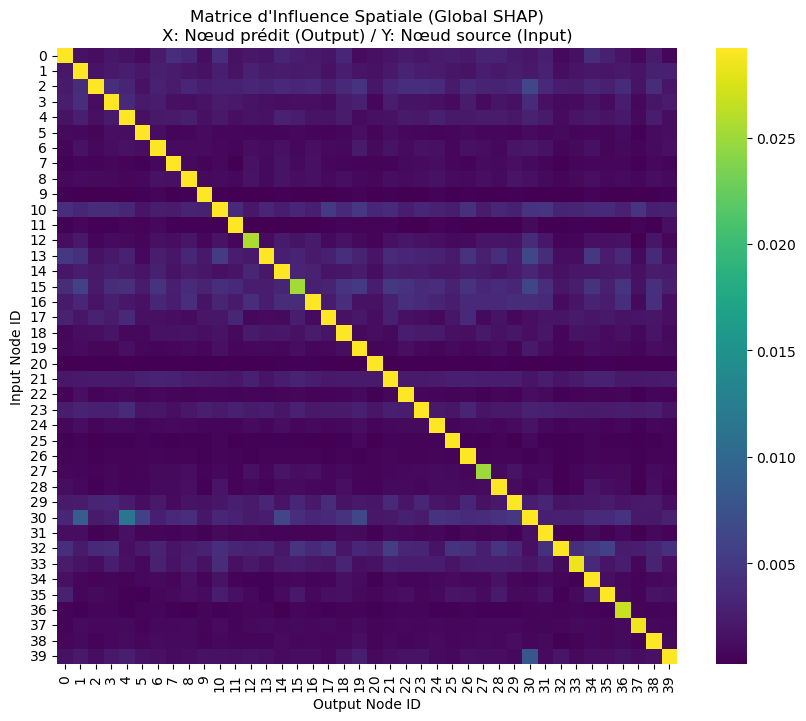

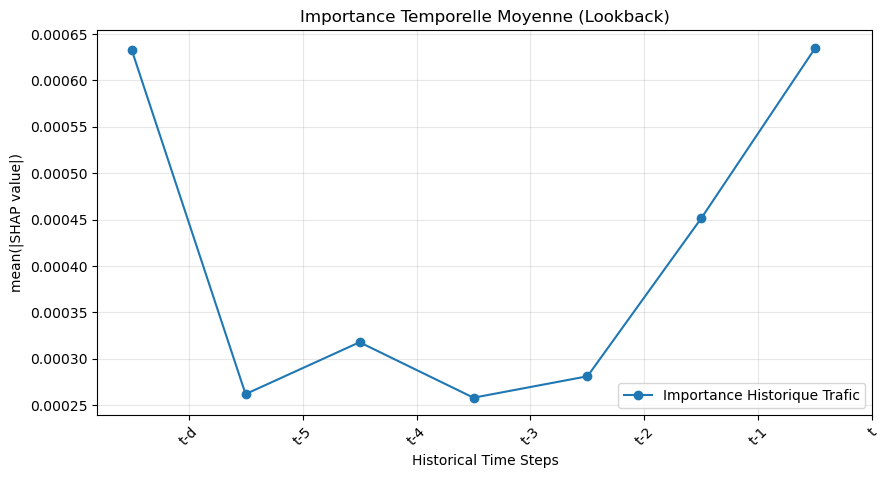

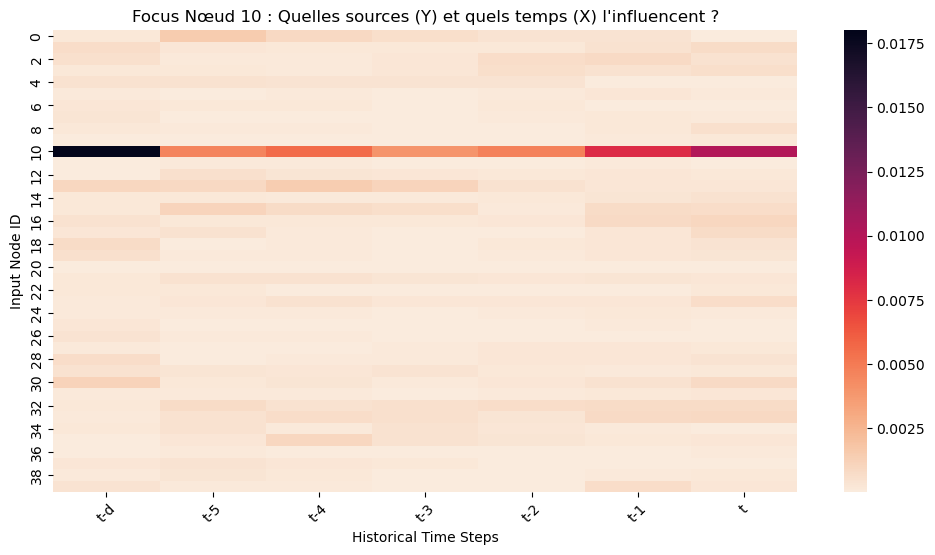

In [55]:
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

# Récupération des données de Input 0 (Subway-Out) 
sv_traffic = shap_values[0] 
xlabels = ["t-d", "t-5", "t-4", "t-3", "t-2", "t-1", "t"] 
# shap_values[1] -> Input 1 (tod) -> importance_traffic [1,L,N]
# shap_values[2] -> Input 2 (dow) -> importance_traffic [1,L,N]
# shap_values[3] -> Input 3 (Subway-In) -> importance_traffic [P,L,N]


# 1. Agrégation sur le Batch (Moyenne des valeurs absolues pour avoir l'importance globale)
importance_traffic = np.mean(np.abs(sv_traffic), axis=0)  # [N,L,N]



# --- VISUALISATION A : Matrice d'Adjacence d'Influence (Spatial Attention) ---
# On somme sur l'axe temporel (axis=1) pour voir l'influence Nœud -> Nœud
spatial_influence = np.sum(importance_traffic, axis=1) # [N,N]

plt.figure(figsize=(10, 8))
sns.heatmap(spatial_influence, cmap='viridis', robust=True)
plt.title("Matrice d'Influence Spatiale (Global SHAP)\nX: Nœud prédit (Output) / Y: Nœud source (Input)")
plt.xlabel("Output Node ID")
plt.ylabel("Input Node ID")
plt.show()


# --- VISUALISATION B : Importance Temporelle (Lookback) ---
# On moyenne sur les Input Nodes et les Output Nodes pour savoir quels pas de temps sont les plus importants
time_imp_traffic = np.mean(importance_traffic, axis=(0, 2))  # [T]

plt.figure(figsize=(10, 5))
x_axis = range(len(time_imp_traffic)) # 0 à 6
plt.plot(x_axis, time_imp_traffic, label='Importance Historique Trafic', marker='o')


# # Pour le Context:
# for input_n in range(len(shap_values)-1):
#     sv_context_i = shap_values[1] 
#     importance_context_i = np.mean(np.abs(sv_context_i), axis=0) 
#     time_imp_context_i = np.mean(importance_context_i, axis=1)   
#     plt.plot(x_axis, time_imp_context_i, label='Importance Variable Contextuelle 1', marker='x', linestyle='--')

plt.title("Importance Temporelle Moyenne (Lookback)")
plt.xlabel("Historical Time Steps")
plt.ylabel("mean(|SHAP value|)")
plt.xticks(ticks=np.arange(len(xlabels))+0.5, labels=xlabels, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# --- VISUALISATION C : Focus sur un Nœud spécifique ---
# Pour comprendre la prédiction du Nœud n°i spécifiquement
target_node = 10

# On isole la tranche le tensor spécifique au Nœud de sortie i:
node_0_explanation = importance_traffic[:, :, target_node]  # [N, L]


plt.figure(figsize=(12, 6))
sns.heatmap(node_0_explanation, cmap='rocket_r')
plt.title(f"Focus Nœud {target_node} : Quelles sources (Y) et quels temps (X) l'influencent ?")
plt.xlabel("Historical Time Steps")
plt.ylabel("Input Node ID")
plt.xticks(ticks=np.arange(len(xlabels))+0.5, labels=xlabels, rotation=45)
plt.show()

In [ ]:
test_images = test_samples[0]

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

shap.image_plot(shap_numpy, -test_numpy)

# Plot Time Series: 

In [ ]:
for exp_i,trials in dic_trials.items():
    if exp_i == 'set_experience_HERE' :#'Exp1_subway_in': #'set_experience_HERE': # set_experience_HERE # 'Exp1_subway_in'# 'Exp4_15min' # 'Exp4' # 'Exp3_bike_15min_h4' # 'Exp3' # 'Exp1'
        for trial_j in trials:
            df_j_all = pd.DataFrame()
            for n_bis in range(1,6):
                file_path = f"{folder_path}/{exp_i}/{dic_exp_to_names[exp_i]}/{trial_j}_bis{n_bis}/Losses_{trial_j}_bis{n_bis}.csv"
                df_j = pd.read_csv(file_path,index_col = 0)
                df_j.columns = [f'Train_{n_bis}',f'Valid_{n_bis}']
                df_j_all = pd.concat([df_j_all,df_j],axis=1)
            plot_TS(df_j_all,width=1500,height=400,bool_show=True,title=f"{exp_i}, {trial_j}",x_datetime = False)